## Imports

### Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.optim as optim
import wandb

### Tensorboard

In [26]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [27]:
writer = SummaryWriter()

### Custom

In [2]:
from cv_geoguessr.data.StreetViewImagesDataset import StreetViewImagesDataset

from cv_geoguessr.grid.grid_partitioning import Partitioning

from cv_geoguessr.utils.plot_images import plot_images

## Colab specific

Run only when using Colab.

In [3]:
COLAB = False

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

## Logging in via WandB

In [3]:
wandb.init(project="CV-GeoGuessr", entity="cv-geoguessr", sync_tensorboard=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: douwe (cv-geoguessr). Use `wandb login --relogin` to force relogin


## Model constants

In [51]:
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 100
CELL_WIDTH = 0.04

SAMPLES_TO_SHOW = 5

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406])
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225])

CITY_BOUNDS_FILE = '../data/metadata/citybounds/london.csv'

COLAB_LONDON_PHOTO_DIR = lambda train: f'/content/drive/MyDrive/Documents/University/2021-2022/CS4245 Computer Vision/data/images/{"train" if train else "test"}/london'
LOCAL_LONDON_PHOTO_DIR = lambda train: f'../data/images/london/{"train" if train else "test"}'
SJOERD_LONDON_PHOTO_DIR = lambda train: f'../data/images/{"train_img" if train else "test_img"}/london/'


LONDON_PHOTO_DIR = LOCAL_LONDON_PHOTO_DIR

SESSION = "douwes_v1_test"
CHECKPOINT_FOLDER = f'../checkpoints/{SESSION}/'


In [16]:
wandb.config.update({"train_batch_size": TRAIN_BATCH_SIZE, "test_batch_size": TEST_BATCH_SIZE, "cell_width": CELL_WIDTH})

### ImageNet setup

In [5]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt

--2022-06-05 01:50:23--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10,23K  --.-KB/s    in 0s      

2022-06-05 01:50:23 (41,1 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [6]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

## Download ResNet50

In [36]:
resnet50 = models.resnet50(pretrained=True, progress=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

resnet50.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
summary(resnet50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Load the data

### Create the data loaders

In [9]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop((224, 224)),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

grid_partitioning = Partitioning(CITY_BOUNDS_FILE, CELL_WIDTH)

train_data_set = StreetViewImagesDataset(LONDON_PHOTO_DIR(True), grid_partitioning, data_transforms)
train_loader = DataLoader(train_data_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_data_set = StreetViewImagesDataset(LONDON_PHOTO_DIR(False), grid_partitioning, data_transforms)
test_loader = DataLoader(test_data_set, batch_size=TEST_BATCH_SIZE, shuffle=True)


### Preview some images

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


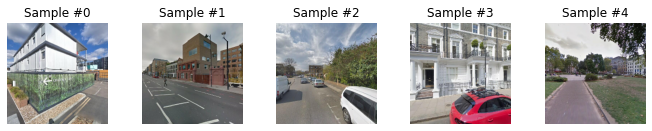

In [11]:
examples = enumerate(test_loader)
batch_idx, (eval_images, eval_coordinates) = next(examples)

plot_images(eval_images[:SAMPLES_TO_SHOW], IMAGENET_MEAN, IMAGENET_STD)

### Preview some output vectors

In [12]:
for i in range(SAMPLES_TO_SHOW):
    print(eval_coordinates[i, :])

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


## Evaluate the model
...with the current/original backbone

In [14]:
resnet50.eval()

with torch.no_grad():
    output = torch.nn.functional.softmax(resnet50(eval_images[:SAMPLES_TO_SHOW]), dim=1)

In [15]:
for i in output:
    top5_prob, top5_catid = torch.topk(i, 5)

    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())

    print("")

greenhouse 0.24143722653388977
patio 0.1461189091205597
picket fence 0.13614065945148468
breakwater 0.11658485233783722
bannister 0.06915049999952316

traffic light 0.15745379030704498
aircraft carrier 0.04463235288858414
prison 0.04081762582063675
maze 0.03875261917710304
unicycle 0.03568131849169731

limousine 0.4693121314048767
minivan 0.13646642863750458
car wheel 0.09222735464572906
trailer truck 0.0499124675989151
moving van 0.036762382835149765

sports car 0.21394428610801697
parking meter 0.15308015048503876
minivan 0.08363138884305954
ashcan 0.07680341601371765
convertible 0.045839156955480576

picket fence 0.17877519130706787
park bench 0.15729576349258423
chainlink fence 0.09175654500722885
breakwater 0.04677620157599449
lakeside 0.043280743062496185



##  Change network backbone to grid cells

In [24]:
lr = 0.001
momentum = 0.9
gamma = 0.1
lr_decay_step = 7
num_epochs = 25

wandb.config.update({"lr": lr, "momentum": momentum, "gamma": gamma, "lr_decay_step": lr_decay_step, "epochs": num_epochs})

In [18]:
from torch.optim import lr_scheduler
from torch import optim

number_of_grid_elements = len(grid_partitioning.cells)

resnet50.fc = nn.Linear(resnet50.fc.in_features, number_of_grid_elements).to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(resnet50.fc.parameters(), lr=lr, momentum=momentum)
NUMBER_OF_GRID_ELEMENTS = len(grid_partitioning.cells)

for param in resnet50.parameters():
    param.requires_grad = False

resnet50.fc = nn.Linear(resnet50.fc.in_features, NUMBER_OF_GRID_ELEMENTS)
resnet50.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# We might not want this for the initial few epochs I (sjoerd) think but lets just roll with it
optimizer_ft = optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=lr_decay_step, gamma=gamma)

In [19]:
summary(resnet50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Set up training pipeline

In [40]:
import copy
from datetime import time

data_loaders = {
    "train": train_loader,
    "val": test_loader
}


data_set_sizes = {
    'train': len(train_data_set),
    'val': len(test_data_set),
}

print(data_set_sizes)

{'train': 10038, 'val': 2000}


In [41]:
import os

if not os.path.isdir(CHECKPOINT_FOLDER):
    os.makedirs(CHECKPOINT_FOLDER)

torch.save(resnet50.state_dict(), CHECKPOINT_FOLDER + "untrained.ckpt")

In [68]:
import copy
import time


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """
    Trains a model, based on https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

    :param model: the model to train
    :param criterion: the criterion to use
    :param optimizer: the optimizer to use
    :param scheduler: torch.optim.lr_scheduler
    :param num_epochs:
    :return: a trained model
    """

    since = time.time()

    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        train_acc = 0
        test_acc = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward: track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                _, actual_label_index = torch.max(labels, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == actual_label_index)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / data_set_sizes[phase]
            epoch_acc = running_corrects.double() / data_set_sizes[phase]

            writer.add_scalar(f"Loss/{phase}", epoch_loss, epoch)
            wandb.log({f"Loss/{phase}": epoch_loss, "epoch": epoch})
            writer.add_scalar(f"Accuracy/{phase}", epoch_acc, epoch)
            wandb.log({f"Accuracy/{phase}": epoch_acc, "epoch": epoch})

            print(f'{phase} loss: {epoch_loss:.4f} | accuracy: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'train':
                train_acc = epoch_acc
            else:
                test_acc = epoch_acc


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())

        print(f"{train_acc}\t{test_acc}")

        torch.save(resnet50.state_dict(),
                   CHECKPOINT_FOLDER + f"epoch_{epoch}.ckpt")

    time_elapsed = time.time() - since

    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model)

    writer.flush()

    return model


## Set up Tensorboard

In [46]:
# Lets train the model
resnet50 = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.3246 Acc: 0.1958
val Loss: 2.2024 Acc: 0.2430

Epoch 1/24
----------
train Loss: 2.1804 Acc: 0.2611
val Loss: 2.1384 Acc: 0.2725

Epoch 2/24
----------
train Loss: 2.1193 Acc: 0.2876
val Loss: 2.0982 Acc: 0.2745

Epoch 3/24
----------
train Loss: 2.0777 Acc: 0.3021
val Loss: 2.0954 Acc: 0.2785

Epoch 4/24
----------
train Loss: 2.0494 Acc: 0.3094
val Loss: 2.0737 Acc: 0.2935

Epoch 5/24
----------
train Loss: 2.0363 Acc: 0.3157
val Loss: 2.0665 Acc: 0.2845

Epoch 6/24
----------
train Loss: 2.0106 Acc: 0.3313
val Loss: 2.0888 Acc: 0.2835

Epoch 7/24
----------
train Loss: 1.9669 Acc: 0.3525
val Loss: 2.0489 Acc: 0.2995

Epoch 8/24
----------
train Loss: 1.9633 Acc: 0.3454
val Loss: 2.0461 Acc: 0.3060

Epoch 9/24
----------
train Loss: 1.9603 Acc: 0.3459
val Loss: 2.0482 Acc: 0.3035

Epoch 10/24
----------
train Loss: 1.9567 Acc: 0.3522
val Loss: 2.0453 Acc: 0.2985

Epoch 11/24
----------
train Loss: 1.9519 Acc: 0.3543
val Loss: 2.0450 Acc: 0.3050

Ep

In [65]:
# load an old model
def load_model(model, PATH, lock_factor, device):
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint)

    model_layers = [module for module in model.children()]
    n = len(model_layers)
    # print(n)  # 10 layers
    # print(model_layers)

    for i, layer in enumerate(model.children()):
        for layer_param in layer.parameters():
            layer_param.requires_grad = i > n * lock_factor

    model.to(device)
    summary(model, (3, 224, 224))

    return model


In [66]:
MODEL_TO_LOAD_PATH = BASE_FOLDER + "/second_test/epoch_24.ckpt"
lock_factor = 0.6

resnet50,  = load_model(resnet50, MODEL_TO_LOAD_PATH, lock_factor, device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [69]:
# now train with the loaded model with more layers unlocked

optimizer_ft = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)
resnet50 = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.9394 Acc: 0.3522
val Loss: 1.9356 Acc: 0.3460
0.3521617852161785	0.34600000000000003
Epoch 1/24
----------
train Loss: 1.5398 Acc: 0.4997
val Loss: 1.9409 Acc: 0.3400
0.4997011356843993	0.34
Epoch 2/24
----------
train Loss: 1.0586 Acc: 0.6793
val Loss: 2.0803 Acc: 0.3430
0.6793185893604303	0.343
Epoch 3/24
----------
train Loss: 0.5380 Acc: 0.8730
val Loss: 2.3005 Acc: 0.3435
0.8729826658696952	0.3435
Epoch 4/24
----------
train Loss: 0.2134 Acc: 0.9652
val Loss: 2.4657 Acc: 0.3460
0.9652321179517832	0.34600000000000003
Epoch 5/24
----------
train Loss: 0.0945 Acc: 0.9890
val Loss: 2.5573 Acc: 0.3495
0.989041641761307	0.34950000000000003
Epoch 6/24
----------
train Loss: 0.0526 Acc: 0.9954
val Loss: 2.6767 Acc: 0.3440
0.9954174138274556	0.34400000000000003
Epoch 7/24
----------
train Loss: 0.0357 Acc: 0.9968
val Loss: 2.7549 Acc: 0.3440
0.9968121139669257	0.34400000000000003
Epoch 8/24
----------
train Loss: 0.0263 Acc: 0.9976
val Loss: 2.7628 Acc: 

In [ ]:
# Lets train the model
trained_model = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)


## Clean up TensorBoard data

In [ ]:
!rm -r runs